ใน ep ที่แล้ว 

# 0. Install

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [2]:
# ## Colab
# ! curl -s https://course.fast.ai/setup/colab | bash

In [3]:
! nvidia-smi

Mon Dec  9 18:22:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    24W /  75W |      0MiB /  7611MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [13]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [14]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

# 2. Dataset

ในเคสนี้เราจะใช้ IMDB Movie Review เป็นรีวิวหนังจากเว็บ IMDB ที่มีข้อความ และ คะแนนว่าเป็นแง่บวก หรือแง่ลบ เหมือนใน ep ก่อน ๆ 

ในการพัฒนา เราจะใช้ Dataset ชุดเล็กก่อน จะได้เร็ว เมื่อเทสทุกอย่างเรียบร้อย แล้วจึงขยับไปใช้ Dataset ชุดเต็ม 

In [15]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

# 3. Preprocessing

## 3.1 Data Block API

เราจะใช้ [Data Block API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) กำหนด Data Pipeline ทีละขั้น Tokenization, Numericalization, Split, Labeling ก็จะทำให้ยืดหยุ่นมากขึ้น

In [16]:
data_lm = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

ดูตัวอย่างคำศัพท์ใน vocab Dictionary

In [8]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

ดูตัวอย่างข้อมูล text

In [9]:
data_lm.train_ds[0][0]

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

ดูข้อมูลภายใน ในรูปแบบตัวเลข

In [10]:
data_lm.train_ds[0][0].data[:20]

array([   2,    5, 4622,   25,    0,   25,  867,   52,    5, 3776,    5, 1800,   95,   37,   85,  191,   63,  936,
          0, 2740])

# 2/2. Full Dataset

Download ชุดข้อมูลตัวเต็ม

In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/26g_imdb_textlist_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup')]

In [18]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat')]

# 3/2. Preprocessing

Data Pipeline ด้วย Data Block API

In [19]:
# bs=48
# bs=24
bs=64

In [20]:
data_lm = (TextList.from_folder(path)
                    .filter_by_folder(include=['train', 'test', 'unsup'])
                    .split_by_rand_pct(0.1)
                    .label_for_lm()
                    .databunch(bs=bs, num_workers=1))

ในข้อมูล Training Set 90,000 Record มีคำศัพท์ 60,000 คำ (Default)

In [16]:
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

In [17]:
data_lm.show_batch()

idx,text
0,"in xxmaj xxunk . xxmaj there - initially much to his horror  xxmaj fosca , the grotesquely ugly cousin of his commander , develops an obsessive love for him . xxmaj he suffers her passionate and demanding displays of affection out of pity and concern for her health ( she is gravely ill ) , but becomes more and more fascinated by her  until the dramatic finale"
1,"a superb sequence . xxmaj this not the best film xxmaj hitch made , but it is surly one of his most entertaining . xxbos i watched this movie on a big screen a few months ago . i did n't know what to expect precisely , and for the first ten minutes i feared i might not enjoy this film . xxmaj it was beginning very slowly , in"
2,kern 's final score and marvel at the quality of xxmaj gershwin 's lyrics and the compatibility of their styles . xxmaj this is a definite gem in the crown of xxmaj columbia 's musical program . xxbos xxmaj well i would say that this is a very enjoyable and somewhat touching movie despite its flaws . i did n't believe for a minute that xxmaj matthau knew the first
3,". xxmaj this film is critical to changing public opinion in order to get rid of the laws that protect harmful people like the xxmaj senior xxmaj social xxmaj worker in "" xxmaj broken xxmaj promise "" . \n \n i strongly recommend xxmaj broken xxmaj promise . xxmaj it is especially appropriate viewing for trainee social workers , psychiatrists , psychologists , doctors , and other xxunk professions"
4,"governor 's offices , and xxmaj cagney becomes a marked man . xxmaj if it sounds silly , it 's not -- the dishonest xxunk practices are only a plot tool ( or as xxmaj hitchcock would say , the mcguffin ) and while unfamiliar , it works every bit as well here as any xxmaj treasury xxmaj agent or g - man anthology in which the fight is taken"


เซฟไว้ก่อน 

In [18]:
data_lm.save('lm_databunch')

โหลด Language Model DataBunch ที่เซฟไว้ แล้วเช็คข้อมูล

In [21]:
data_lm = load_data(path, 'lm_databunch', bs=bs)
len(data_lm.vocab.itos), len(data_lm.train_ds)

(60000, 90000)

# 4. Language Model จาก WikiText-103

## 4.1 AWD LSTM Model

สร้าง Language Model Learner ขึ้นมา โดยใช้ data_lm จาก IMDB ด้านบน และ สถาปัตยกรรม AWD_LSTM [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) โดยที่ยังไม่ได้เริ่มต้นเทรน

AWD_LSTM ได้ถูก Pre-Train กับ WikiText-103 Dataset เรียบร้อยแล้ว

In [22]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, 
                                  drop_mult=0.3, 
                                  callback_fns=[ShowGraph, PeakMemMetric])
# learn_lm

In [16]:
learn_lm.model[0]

AWD_LSTM(
  (encoder): Embedding(60000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(60000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [17]:
learn_lm.model[0].encoder

Embedding(60000, 400, padding_idx=1)

## 4.2 vocab Dictionary ของ WikiText-103 

โหลด Dictionary ของ WikiText-103 ขึ้นมา 

Language Model ต้องมาพร้อมกับ vocab Dictionary เสมอ ไม่เช่นนั้นเราจะไม่รู้ว่า คำศัพท์ไหนเป็นคำไหน เพราะในโมเดลจะเป็นตัวเลข Index / Embedding

In [18]:
Config().model_path().ls()

[PosixPath('/home/jupyter/.fastai/models/wt103-fwd'),
 PosixPath('/home/jupyter/.fastai/models/wt103-fwd.tgz')]

In [19]:
(Config().model_path()/'wt103-fwd').ls()

[PosixPath('/home/jupyter/.fastai/models/wt103-fwd/itos_wt103.pkl'),
 PosixPath('/home/jupyter/.fastai/models/wt103-fwd/lstm_fwd.pth')]

In [20]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

ดูจำนวนคำศัพท์ ตัวอย่างข้อมูล หัว / ท้าย

In [21]:
len(wiki_itos), wiki_itos[:20], wiki_itos[-20:]

(60000,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  ',',
  '.',
  'of',
  'and',
  'in',
  'to',
  'a',
  '=',
  '"',
  'was'],
 ['repaying',
  'ak-47',
  'cultic',
  'jaume',
  'leonis',
  'subtracting',
  'sexed',
  'bursa',
  '-style',
  'lithographs',
  'wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'])

## 4.3 vocab Dictionary ของ IMDB

ดูตัวอย่างคำศัพท์ใน IMDB

In [22]:
vocab = data_lm.vocab

In [23]:
imdb_itos = vocab.itos

In [24]:
vocab.stoi['love']

134

In [25]:
imdb_itos[vocab.stoi['love']]

'love'

In [26]:
imdb_itos[vocab.stoi['Sukhumvit']]

'xxunk'

In [27]:
awd = learn_lm.model[0]

In [28]:
# from scipy.spatial.distance import cosine as dist

In [29]:
enc = learn_lm.model[0].encoder

Embedding 400 มิติของ คำศัพท์ 60,000 คำ

In [30]:
enc.weight.size()

torch.Size([60000, 400])

## 4.4 Difference in vocab between IMDB and Wikipedia

เปรียบเทียบ 2 vocab Dictionary พบว่า ขนาด vocab เท่ากัน

In [31]:
len(wiki_itos), len(imdb_itos)

(60000, 60000)

แต่ข้างใน ไม่เหมือนกัน เปรียบเทียบ 10 คำศัพท์สุดท้าย

In [32]:
wiki_itos[-10:], imdb_itos[-10:]

(['wgbh',
  'subsystem',
  '831',
  'lifelines',
  'bergeron',
  'adaptions',
  'slurs',
  'acasta',
  'stuccoed',
  'spellbound'],
 ['parrying',
  'zieff',
  'catnip',
  'reflexions',
  'doy',
  'tug-3',
  'lisztomania',
  'coif',
  'ermanno',
  'caspian'])

In [33]:
wiki_words = set(wiki_itos)
imdb_words = set(imdb_itos)

คำศัพท์ที่อยู่ใน vocab ของ Wiki แต่ไม่อยู่ใน vocab ของ IMDB

In [34]:
wiki_not_imdb = wiki_words.difference(imdb_words)
len(wiki_not_imdb), [val for i, val in enumerate(itertools.islice(wiki_not_imdb, 20))]

(24249,
 ['parthians',
  'fracturing',
  'banqueting',
  'eazy',
  'daspletosaurus',
  'grassland',
  'tabari',
  'molybdenum',
  'hetch',
  'coronae',
  'troon',
  'zaculeu',
  'parturition',
  'oxendine',
  'avars',
  'phosphate',
  'qingdao',
  'cdot',
  'litre',
  'allman'])

คำศัพท์ที่อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน vocab ของ Wiki

In [35]:
imdb_not_wiki = imdb_words.difference(wiki_words)
len(imdb_not_wiki), [val for i, val in enumerate(itertools.islice(imdb_not_wiki, 20))]

(24249,
 ['klemperer',
  'shim',
  'kitschy',
  '.see',
  'shadowzone',
  'serbedzija',
  'phoning',
  '\x85\x85\x85\x85',
  'bachan',
  'keefer',
  'hallstrom',
  'tracie',
  'overhear',
  'swankiest',
  'bishof',
  '1000-word',
  'sushma',
  'debunking',
  'whodunits',
  'bevy'])

## 4.5 Out of vocab Initialization

คำว่า verification อยู่ใน vocab ของ WikiText-103 แต่ไม่อยู่ใน IMDB

In [36]:
w = "verification"
vocab.stoi[w], w in wiki_words, w in imdb_words

(0, True, False)

คำเหล่านี้ อยู่ใน vocab ของ IMDB แต่ไม่อยู่ใน WikiText-103 เราจะ Initialize Embedding ของคำเหล่านี้ แบบ Random

In [37]:
w = "senselessness"
vocab.stoi[w], w in wiki_words, w in imdb_words

(35203, False, True)

In [38]:
w = "unthinking"
vocab.stoi[w], w in wiki_words, w in imdb_words

(26730, False, True)

In [39]:
w = "forklift"
vocab.stoi[w], w in wiki_words, w in imdb_words

(43386, False, True)

Initialize ด้วยค่า Random เล็ก ๆ ใกล้เคียงกัน

In [40]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

True

แต่ถ้าเทียบกับ Embedding ที่เทรนเรียบร้อยแล้ว ก็จะต่างกันมาก

In [41]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['capital'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [42]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(35203, 26730, 5775, 59669)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าเท่ากันมีค่าเท่ากัน

In [43]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

In [44]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([ 0.0253,  0.0026,  0.0423, -0.0274, -0.0110, -0.0100, -0.0628,  0.1794,
         -0.1275, -0.2096, -0.0124, -0.0056, -0.0505, -0.0501, -0.0428,  0.1726,
         -0.0650, -0.0571, -0.1103,  0.0186,  0.0053, -0.0059,  0.0299,  0.0192,
         -0.0240,  0.1432, -0.1064, -0.0097,  0.0100, -0.0399,  0.0282,  0.0319,
          0.1297,  0.0687, -0.0047,  0.0168,  0.0201,  0.1346, -0.0336, -0.0449,
          0.0265, -0.0756, -0.0225,  0.0196,  0.0221,  0.0214,  0.0077, -0.1311,
         -0.1357, -0.0128], device='cuda:0', grad_fn=<SliceBackward>))

ต่างกับค่าที่มีใน Wiki

In [45]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400,
 tensor([-0.2566,  0.1062,  0.3081,  0.2742,  0.1667, -0.1626, -0.5122, -0.1261,
          0.4548, -0.4177, -0.1565,  0.0752,  0.2253,  0.2031, -0.3125,  0.0310,
          0.5112, -0.3691, -0.2947, -0.0168, -0.1147,  0.3074, -0.1654, -0.2202,
          0.0538, -0.4041,  0.1666, -0.0109, -0.2803,  0.3044, -0.2279,  0.1786,
         -0.2502, -0.2334,  0.4438,  0.2404,  0.1746,  0.1509,  0.0351,  0.2844,
         -0.0244, -0.2031,  0.1228, -0.2357, -0.2065,  0.5811,  0.1338,  0.4087,
         -0.5034, -0.0150], device='cuda:0', grad_fn=<SliceBackward>))

## 4.6 Fake Movie Reviews from WikiText Language Model

ชอบหนังเรื่องนี้เพราะว่า

In [46]:
TEXT = "I loved this film because"
N_WORDS = 60
N_SENTENCES = 3

In [47]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I loved this film because of its ability to make a film about someone else 's life or death . It is a very rare film , and Michael Yates was hired to direct it , and it was him to be a writer for the film . The director is also a writer for the American film The
I loved this film because the script was " a little bit more elaborate " than the film , and the movie was to be a " classic " . The idea for a sequel was met with controversy , with David Mendelsohn , a British Channel Five correspondent , quoted in a 2002 article as saying , "
I loved this film because it was one of his most common films . Incorporating the film 's sex scene into the film , he wrote and sung the song " You Are the Only One That is In Life " , which the French actress Luc Besson shot in the scene with


ไม่ชอบหนังเรื่องนี้เพราะว่า

In [48]:
TEXT = "I hated this movie because"
N_WORDS = 60
N_SENTENCES = 3

In [49]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie because of its association with a film . The film was also well - received by critics . The New York Times 's Robert Bianco described the film as " bland , confusing , and quite overly entertaining " , while Peter Travers of Rolling Stone called it " a
I hated this movie because it was not a " horror " . Using a spy film , the film was released on DVD as a double album , release it as a DVD . It is now available on commercial DVD . 
 
  = = Reception = = 
 
  The film was released on DVD and
I hated this movie because it was like Queen Elizabeth i was a child . It was adopted by the British Royal Navy . Biographer Edward Kerr notes that Agatha is an example of the film 's violence , and that there are no other elements of the video that were viewed as " explicitly


หนังเรื่องนี้ ... จริง ๆ

In [50]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [51]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is really the first film shown in the United States ; MGM ; William Blackstone and Richard Wright ; Frank Studios , Hollywood ; Thomas Edison ; and Walter Jackson . In February 2012 , the first U.S. state - sponsored film and radio show
This movie is really a parody of the American film The King of Pop , in which King George v is the King of Britain . The film , portrayed by John Adams , is directed by Mark Kirkland , and portrays King George VI , who inaugural
This movie is really a film that is a very different from the Mario Kart franchise , and therefore the film is not a classic . As a result , Fox Interactive 's Los Angeles Productions , Fox Searchlight Pictures , Universal Pictures , and Fox Pictures folded the


ลด temperature ลง ทำให้ข้อความ Random น้อยลง

In [52]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [53]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

This movie is really a British film , and it is not a direct sequel to The Lord of the Rings . The film was released on DVD in November 2007 . The film was released on DVD in November 2007 , and in November 2008 in the United Kingdom .
This movie is really a British film , and it is not a direct sequel to The Lord of the Rings . The film was released on DVD in November 2010 . The film was released on DVD in November 2010 . 
 
  = = Reception = = 
 
  The Guardian
This movie is really a British film , and is a direct reference to the British film The Lord of the Rings . The film was released on DVD in November 2007 , and in Europe on October 1 , 2007 . The film was released on DVD in North


# 5. Train Model

## 5.1 Train Last Layer

เทรน Layer สุดท้าย

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-03


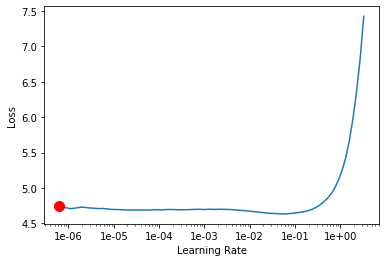

In [54]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [55]:
lr = 3e-2

In [56]:
learn_lm.to_fp16();

In [57]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8, 0.7), 
                       callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,4.249955,3.621373,0.371429,43:07


In [61]:
learn_lm.save("26g-01")

In [64]:
learn_lm.load("26g-01");

## 5.2 Unfreeze and Train whole model

In [65]:
learn_lm.unfreeze()

Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.20E-04


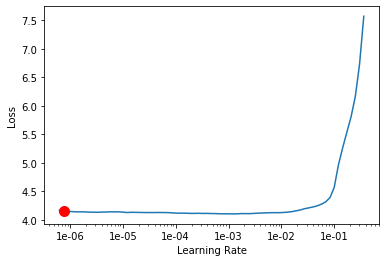

In [68]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)

In [69]:
lr = slice(1e-6, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.032920,3.500813,0.414286,50:54
1,3.981747,3.455713,0.428571,50:53
2,3.931693,3.372495,0.414286,50:54
3,3.915625,3.288931,0.442857,50:51
4,3.876479,3.239455,0.428571,50:51
5,3.841878,3.287216,0.414286,50:51
6,3.828056,3.251661,0.428571,50:53
7,3.827854,3.245939,0.414286,50:54
8,3.794521,3.241598,0.414286,50:53
9,3.790094,3.236650,0.414286,50:50


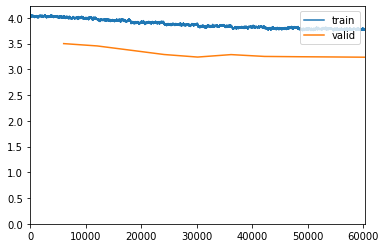

In [75]:
learn_lm.fit_one_cycle(10, max_lr=lr, moms=(0.8, 0.7), 
                      callbacks=[SaveModelCallback(learn_lm, every='epoch', monitor='accuracy')])

In [76]:
learn_lm.save("26g-02")

In [77]:
learn_lm.save_encoder("26g-02-enc")

In [23]:
learn_lm.load("26g-02");

## 5.3 Check Embedding Again

ลองเช็คอีกครั้ง หลังจากเทรนเสร็จแล้ว Embedding ของทั้ง 2 คำ มีค่าต่างกันแล้ว

In [78]:
np.allclose(enc.weight[vocab.stoi['senselessness'], :], 
            enc.weight[vocab.stoi['unthinking'], :])

False

3 คำแรกมีใน IMDB แต่คำสุดท้ายไม่มี

In [80]:
vocab.stoi['senselessness'], vocab.stoi['unthinking'], vocab.stoi['capital'], vocab.stoi['cpu']

(35203, 26730, 5775, 59669)

ดู Embedding ของคำที่มีใน IMDB แต่ไม่มีใน Wiki จะเห็นว่าแต่ละคำค่า Embedding ได้เปลี่ยนไปเรียบร้อยแล้ว ไม่มีคำไหนค่าซ้ำกันเลย

In [85]:
len(enc.weight[vocab.stoi['senselessness'], :]), enc.weight[vocab.stoi['senselessness'], :][:50]

(400,
 tensor([ 0.1224, -0.6694, -0.2054,  0.6274, -0.4873, -0.7456,  0.2047,  0.5698,
         -0.6025, -0.6812,  0.1405, -0.3894, -0.5239, -0.3218,  0.3420,  0.7729,
         -0.1395,  0.0392, -0.8257,  0.0452, -0.5801,  0.1185,  0.2291, -0.0627,
         -0.1638,  0.0775,  0.0053, -0.2571,  0.9458,  0.0737, -0.1927,  0.1714,
          0.9570,  0.4788, -0.0369,  0.4170,  0.4446, -0.1305,  0.1366, -0.5181,
          0.8120, -1.5205, -0.8071,  0.3977,  0.1952, -0.1271, -0.5962, -0.7720,
         -0.7632,  0.7969], device='cuda:0', dtype=torch.float16,
        grad_fn=<SliceBackward>))

In [86]:
len(enc.weight[vocab.stoi['unthinking'], :]), enc.weight[vocab.stoi['unthinking'], :][:50]

(400,
 tensor([-0.3477, -0.0908,  0.0530, -0.2450, -0.4429, -0.1631, -0.0114,  0.1377,
          0.0904, -1.0977, -0.0850,  0.8584, -0.2703, -0.3167, -1.1924,  0.7695,
         -0.4045, -0.0170, -0.2595,  0.0365, -0.8438, -0.8374,  0.4578, -0.0986,
          0.2062, -0.1838, -0.0183, -0.6616, -0.5776, -0.9878, -0.6177,  0.6006,
          0.9126,  0.5083,  0.4792, -1.1719, -0.8950,  0.3687, -0.0936,  0.2191,
          0.1821, -1.2637, -0.5366,  0.6582,  0.0194, -0.2578,  0.7749, -0.5820,
         -1.2959,  0.3721], device='cuda:0', dtype=torch.float16,
        grad_fn=<SliceBackward>))

In [87]:
len(enc.weight[vocab.stoi['capital'], :]), enc.weight[vocab.stoi['capital'], :][:50]

(400, tensor([-9.8047e-01, -7.6367e-01,  3.6835e-02,  4.0796e-01,  3.1958e-01,
         -1.0098e+00, -3.7354e-01,  1.7151e-01,  4.1650e-01,  3.5156e-01,
         -2.8442e-01,  1.8103e-01, -7.5732e-01, -6.8994e-01,  3.9331e-01,
          1.5615e+00,  7.7148e-01, -8.4619e-01, -1.0889e+00, -3.2196e-02,
         -1.1359e-01,  1.5430e+00,  7.8418e-01, -3.3984e-01,  3.1177e-01,
          1.3107e-02,  1.2100e+00, -6.9727e-01, -3.0127e-01,  1.6138e-01,
          5.0830e-01,  1.1289e+00, -1.0956e-01,  1.9562e-02,  1.1835e-01,
          6.6699e-01,  6.5820e-01,  1.1129e-03, -4.9170e-01,  1.0663e-01,
         -2.1155e-01, -1.9629e+00, -1.1416e+00,  1.5784e-01,  6.1182e-01,
          1.8018e+00, -3.0933e-01,  3.0426e-02, -9.9463e-01,  1.7664e-01],
        device='cuda:0', dtype=torch.float16, grad_fn=<SliceBackward>))

## 5.4 Fake Movie Reviews from IMDB Language Model

เราจะลอง Generate รีวิวหนัง Movie Reviews ใหม่จาก Language Model ที่เราเพิ่งเทรนกับ IMDB DataSet เสร็จ

ชอบหนังเรื่องนี้เพราะว่า

In [96]:
TEXT = "I loved this film because"
N_WORDS = 60
N_SENTENCES = 3

In [97]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I loved this film because it was sort of a bad film , but that was just not bad . The background score , the bad it was bizarre . 
 
  The film was a very interesting show . i hope that Bonnie Hunt will be the next Golden Globe nominated actress . The combination of Scarlett
I loved this film because i was hoping for some funny scenes . The movie was over the top , and i stopped laughing because i thought the movie was not worth watching . The movie is also funny , but all of the actors were pretty bad . The whole movie was very boring , i was very bored and had
I loved this film because it had a great premise . That brought home the feeling she had been on the screen at the time , and it reminded me of Ms. Moore 's famous " The Touch of Evil . " And i think the movie is a good idea . With a great cast i


ไม่ชอบหนังเรื่องนี้เพราะว่า

In [90]:
TEXT = "I hated this movie because"
N_WORDS = 60
N_SENTENCES = 3

In [91]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie because it has no plot whatsoever and this movie is a total waste . The plot is a typical series of slasher movies that have you do nt take the genre seriously . The plot is basically a mad comedy with a couple of naked women in the middle of the movie . The acting is so bad
I hated this movie because it was nothing more than a bunch of movies . The plot was predictable , the characters were n't believable . The story had a couple of sub - plots and everything seemed to be in a different direction . It was like watching a TV movie if you had n't seen it or it was
I hated this movie because i love people who hate it and have to believe in the woman that she was of during the Vietnam War . But i think that 's a lot of people who are so really offended by this movie . i ca n't understand why this movie is so bad . This movie is a very


หนังเรื่องนี้ ... จริง ๆ

In [92]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [93]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie is really great . If i bought it then i 'd see it . It was a complete chase scene , so i knew i was going to stay with Lewis , but he 's a hot figured - out . Yeah , the movie was great . It still holds up to the best of the
This movie is really weak . It is also a very violent movie . It is not that bad . Just a few major changes of plot . 
 
  The plot was an sub - par one , with the main characters all walking around and each other with a killer being a beast . This one was actually
This movie is really very good . The acting is excellent . The dialogue is written and acted by James Admitting , who is the only actor on the big screen . The actors re - read the book to make a quick , convincing movie , and the Fluff character is n't much - developed .


ลด temperature ลง ทำให้ข้อความ Random น้อยลง

In [94]:
TEXT = "This movie is really"
N_WORDS = 60
N_SENTENCES = 3

In [95]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

This movie is really bad . It 's not even funny . It 's not funny . It 's not funny . It 's not funny . It 's not funny . It 's not funny . It 's not funny . It 's just plain stupid . It 's just plain stupid .
This movie is really bad . It 's not even funny . The acting is terrible , the script is terrible , the acting is terrible , the script is bad , the acting is bad , the script is bad , the acting is bad , the directing is bad , the directing is bad , the acting is bad ,
This movie is really bad . It 's not even funny . It 's not funny , it 's just plain stupid . It 's just plain stupid . It 's just plain stupid . It 's just plain stupid . The acting is terrible , the acting is bad , the acting is bad , the script


# 6. Classifier

## 6.1 สร้าง Databunch ใหม่สำหรับ Classifier

ใช้ Data Block API สร้าง Data Pipeline ใหม่ สำหรรับงาน Classifier ที่จะมี label เป็น positive, negative

In [24]:
bs = 48

In [25]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg', 'pos'])
            .databunch(bs=bs, num_workers=8))

In [100]:
data_clas.save('26g_imdb_textlist_clas')

In [26]:
data_clas = load_data(path, '26g_imdb_textlist_clas', bs=bs, num_workers=8)

In [27]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * ! ! - xxup spoilers - ! ! * \n \n xxmaj before i begin this , let me say that i have had both the advantages of seeing this movie on the big screen and of having seen the "" xxmaj authorized xxmaj version "" of this movie , remade by xxmaj stephen xxmaj king , himself , in 1997 . \n \n xxmaj both",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n \n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first",neg
"xxbos xxmaj the freedom of having your own xxmaj sea xxmaj going xxmaj power xxmaj boat , the excitement of going on underwater adventures a rugged , an 's man of an adventurer and xxunk so well endowed ! ) assistants in fine xxmaj bikinis were all definite selling points for "" xxup sea xxup xxunk - 61 ) . \n \n xxmaj just what was the reason for",pos
"xxbos xxmaj prior to this release , xxmaj neil labute had this to say about the 1973 original : "" xxmaj it 's surprising how many people say it 's their favorite soundtrack . i 'm like , come on ! xxmaj you may not like the new one , but if that 's your favorite soundtrack , i do n't know if i * want * you to like",neg


## 6.2 สร้าง Learner สำหรับงาน Classifier

สร้าง learner สำหรับงาน Classifier แล้ว Load Encoder จาก Language Model ที่เทรนไว้ด้านบน เป็นการ Transfer Learning เรียกว่า ULMFit

In [28]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, 
                                     drop_mult=0.3, 
                                     callback_fns=[ShowGraph, PeakMemMetric]).to_fp16()

In [29]:
learn_clas.load_encoder('26g-02-enc')
learn_clas.freeze()

## 6.3 เทรน Layer สุดท้าย

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.02E-02


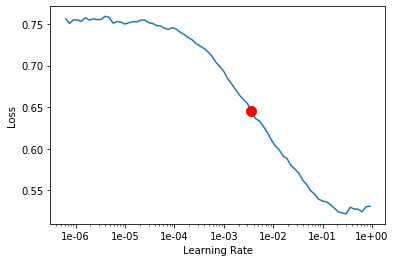

In [109]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [110]:
lr = 3e-2

In [111]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.303565,0.249903,0.897440,04:22


In [112]:
learn_clas.save('26g-21')

In [113]:
learn_clas.load('26g-21');

## 6.4 ค่อย ๆ Unfreeze แล้วเทรน Layer Group ต่อ ๆ มา

In [114]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-07


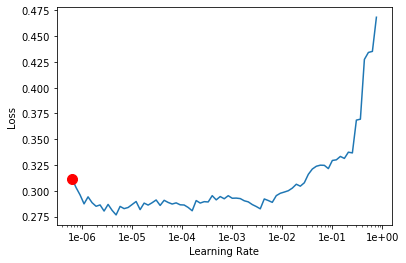

In [115]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [116]:
lr = 3e-4

In [117]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.289124,0.227785,0.908520,05:11


In [112]:
learn_clas.save('26g-22')

In [113]:
learn_clas.load('26g-22');

## 6.5 ค่อย ๆ Unfreeze แล้วเทรน Layer Group ต่อ ๆ มา

In [118]:
learn_clas.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 3.31E-05


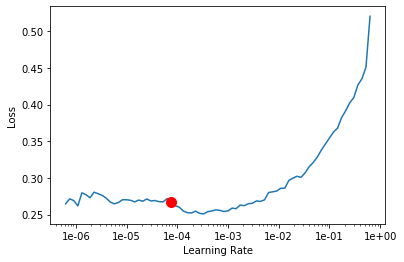

In [119]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [120]:
lr = 3e-5

In [121]:
learn_clas.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.273182,0.219209,0.912280,06:21


In [122]:
learn_clas.save('26g-23')

In [44]:
learn_clas.load('26g-23');

## 6.6 Unfreeze แล้วเทรนทั้งโมเดล

In [31]:
learn_clas.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


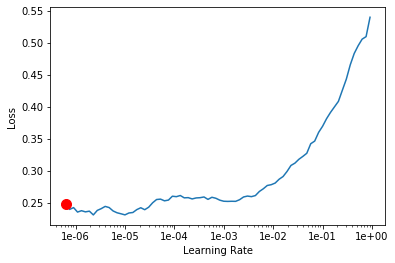

In [124]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [45]:
lr = 1e-4

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak,time
0,0.238589,0.204887,0.920960,0,1,534,5616,07:56
1,0.219932,0.181843,0.930400,10,11,0,5680,08:43
2,0.176504,0.171677,0.934720,0,1,0,5664,08:43
3,0.160201,0.172728,0.934360,0,1,0,5712,09:01


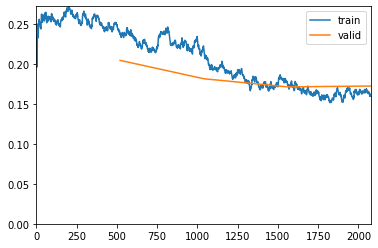

In [46]:
learn_clas.fit_one_cycle(4, max_lr=lr, moms=(0.8, 0.7))

โมเดลของเรา สามารถ Predict IMDB DataSet Sentiment Classification ได้ Accuracy ถึง 94%

In [47]:
learn_clas.save('26g-24')

In [48]:
learn_clas.load('26g-24');

## 6.7 Predict

รีวิวแง่บวก

In [49]:
learn_clas.predict('It is possibly the most completely wonderful story I have ever watched.')

(Category pos, tensor(1), tensor([0.0020, 0.9980]))

In [50]:
learn_clas.predict('An intelligent, charming, sweet film with surprising depth and heart.')

(Category pos, tensor(1), tensor([1.6898e-05, 9.9998e-01]))

In [51]:
learn_clas.predict("I for one thought that this is an effective action movie that was really entertaining. I don't know what people's problem is that they have to dump on this movie so bad.")

(Category pos, tensor(1), tensor([0.1965, 0.8035]))

รีวิวแง่ลบ

In [52]:
learn_clas.predict('Big disappointment even for non-discriminating zombie movie fans.')

(Category neg, tensor(0), tensor([0.9906, 0.0094]))

In [53]:
learn_clas.predict("Truly appalling This is an action movie by numbers... but the action isn't very exciting and the plot holes just annoy. ")

(Category neg, tensor(0), tensor([0.9975, 0.0025]))

In [54]:
learn_clas.predict('A terrible "action" film that is more accidentally humorous than seriously suspenseful.')

(Category neg, tensor(0), tensor([0.9982, 0.0018]))

# สรุป

* เราได้เรียนรู้ว่า 

# Credit

* https://www.youtube.com/watch?v=dt7sArnLo1g&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=6&t=0s
* https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://www.bualabs.com/archives/3000/sentiment-classification-imdb-movie-reviews-with-naive-bayes-logistic-regression-nlp-ep-5/
* https://docs.fast.ai/data_block.html
* https://docs.fast.ai/text.data.html
* https://forums.fast.ai/t/language-model-zoo-gorilla/14623
* https://www.imdb.com/interfaces/
* https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/
* https://arxiv.org/abs/1801.06146